This is an exmaple notebook where we are considering a dataset thay includes tweets and news articles on the Russia-Ukraine War

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

filename = "../data/tweets_main_sentiment.csv"
df = pd.read_csv(filename)

In [12]:
df

,id,username,content,sentiment
0,1663696515326517248,The_NewDispatch,Ukraine Shoots Down 52 Of 54 Iranian Made Dron...,negative
1,1663696124392136705,KabalexChild,"Legion ""Freedom of Russia"" recruits thousands ...",negative
2,1663695373485973504,GuardianAus,Russia-Ukraine war at a glance: what we know o...,neutral
3,1663695317819351041,VSNRadio,Russia-Ukraine war at a glance: what we know o...,neutral
4,1663694952424169475,tdhoanh,Drone strikes in capital bring Ukraine war to ...,negative
...,...,...,...,...
6125,1662868597406945281,geoengineering1,"“For the AMO, the low contrast between the col...",neutral
6126,1662868537973563396,geoengineering1,"“In contrast, the spatial anomaly pattern chan...",neutral
6127,1662868477219053570,geoengineering1,“The projected spatial patterns of SST anomaly...,neutral
6128,1662868441253007362,mongi_writes,Let’s face it developers. Global warming has g...,neutral


Exploring the collected dataset and also making some basic visualisations

In [14]:
df.describe()

,id
count,6.130000e+03
mean,1.662860e+18
std,1.026804e+16
min,1.131165e+18
25%,1.663106e+18
50%,1.663284e+18
75%,1.663552e+18
max,1.663697e+18


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6130 entries, 0 to 6129
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         6130 non-null   int64 
 1   username   6130 non-null   object
 2   content    6130 non-null   object
 3   sentiment  6130 non-null   object
dtypes: int64(1), object(3)
memory usage: 191.7+ KB


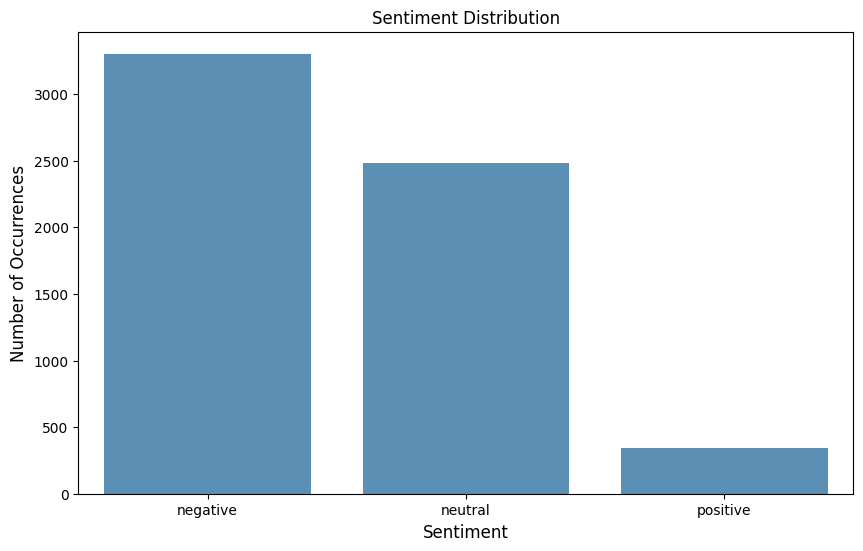

In [16]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=sentiment_counts.index,y=sentiment_counts.values, alpha=0.8)
plt.title('Sentiment Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.show()

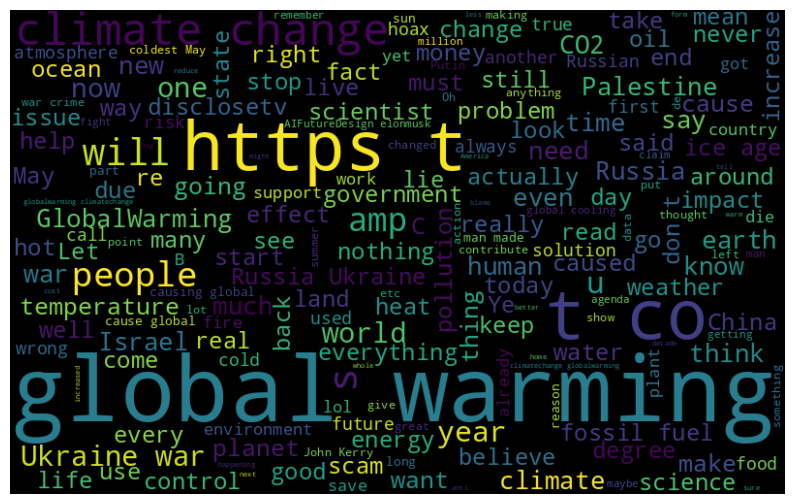

In [18]:
all_text = ' '.join(df['content'])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

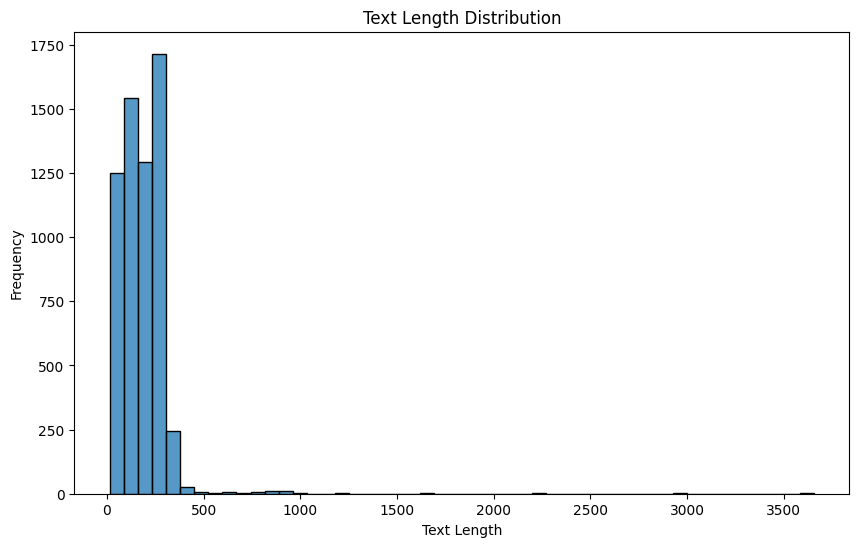

In [19]:
df['text_length'] = df['content'].apply(len)

# Histogram
plt.figure(figsize=(10,6))
sns.histplot(df['text_length'], bins=50)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

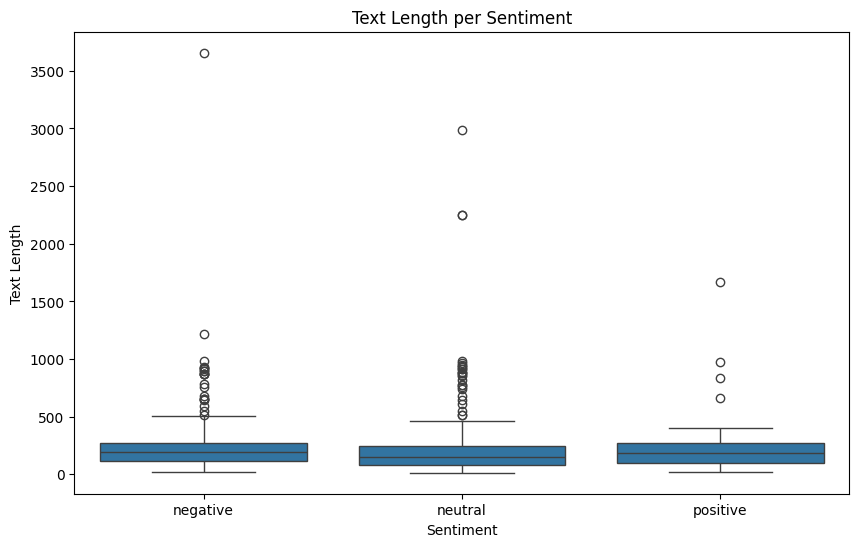

In [20]:
plt.figure(figsize=(10,6))
sns.boxplot(x='sentiment', y='text_length', data=df)
plt.title('Text Length per Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()

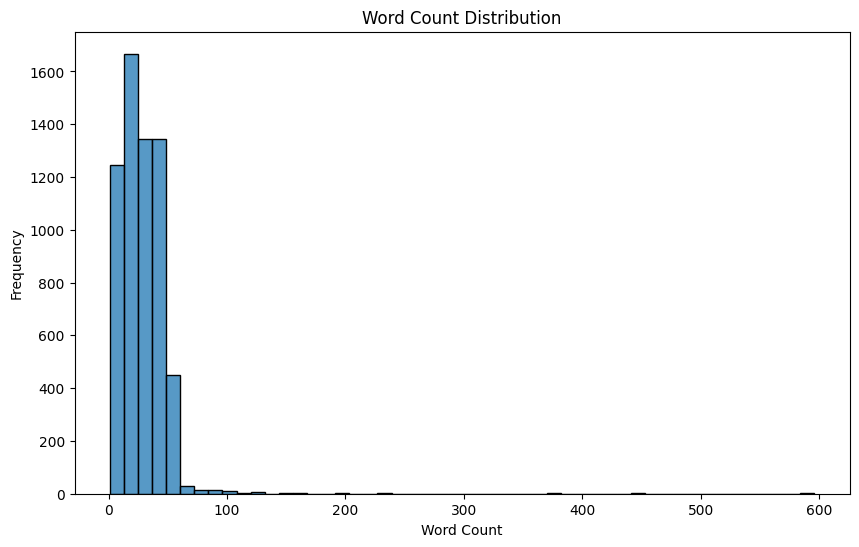

In [21]:
df['word_count'] = df['content'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,6))
sns.histplot(df['word_count'], bins=50)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

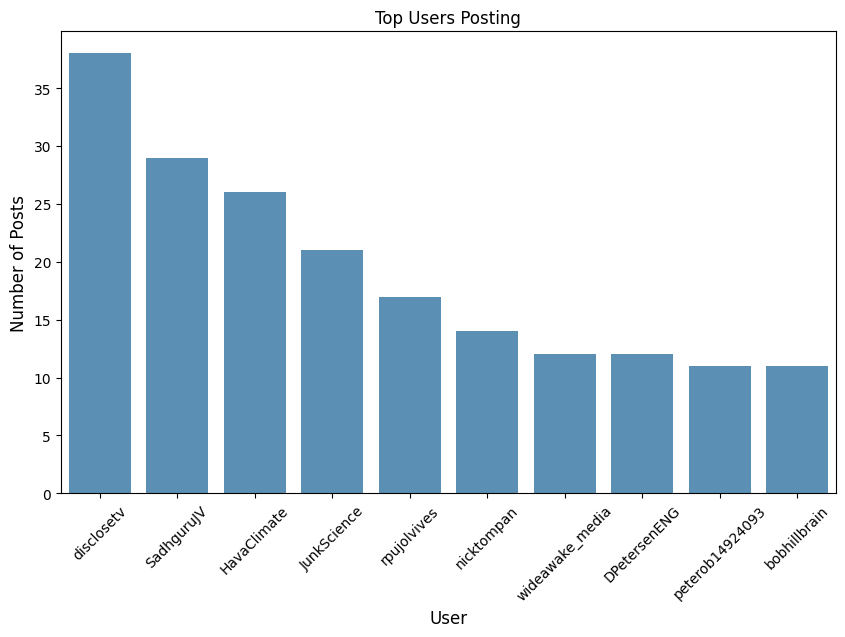

In [22]:
user_counts = df['username'].value_counts().head(10)

# Bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=user_counts.index, y=user_counts.values, alpha=0.8)
plt.title('Top Users Posting')
plt.ylabel('Number of Posts', fontsize=12)
plt.xlabel('User', fontsize=12)
plt.xticks(rotation=45)
plt.show()

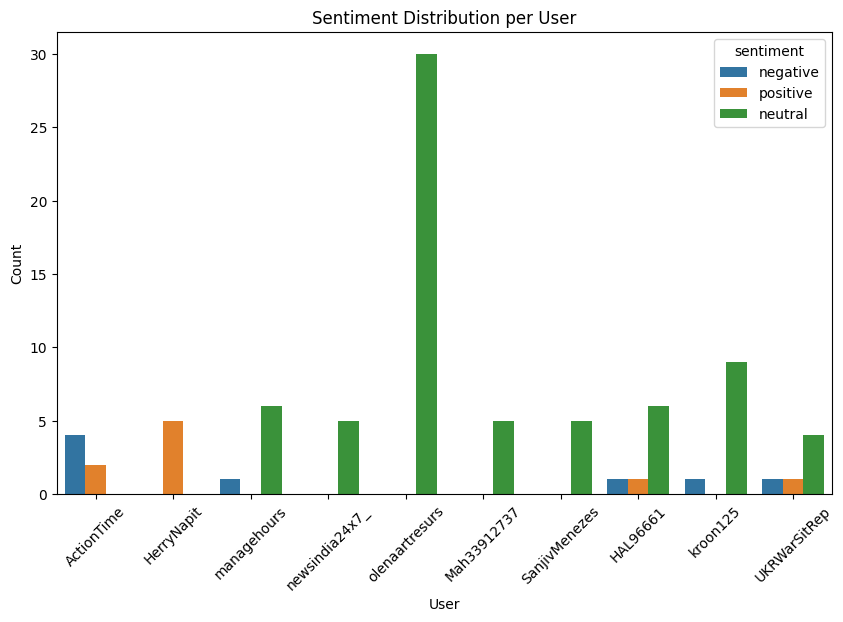

In [11]:
top_users_df = df[df['user'].isin(user_counts.index)]

plt.figure(figsize=(10,6))
sns.countplot(x='user', hue='sentiment', data=top_users_df)
plt.title('Sentiment Distribution per User')
plt.xlabel('User')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

We will now start training the model. Importing all libraries needed to train the model

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

Preprocess text data

In [34]:
df['content'] = df['content'].apply(lambda x: x.lower())  # convert to lowercase

le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

Split data into training and testing sets

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['sentiment'], test_size=0.2, random_state=42)

Create a pipeline   

The first step in our pipeline is ('tfidf', TfidfVectorizer(stop_words='english')). Here, we're using the TfidfVectorizer class to convert the text data into a matrix of TF-IDF features. We're also specifying stop_words='english' to remove all common pronouns ("a", "and", "the", etc.) to reduce the number of uninformative features.

The second step is ('svd', TruncatedSVD(n_components=100, random_state=42)). In this step, we're reducing the dimensionality of our TF-IDF matrix using Truncated Singular Value Decomposition (SVD). We're specifying n_components=100 to reduce the data to 100 features, and random_state=42 to ensure that the results are reproducible.

The third step is ('feature_selection', SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'))). Here, we're performing feature selection using a logistic regression model with L1 regularization as the estimator. This step will help us select the most important features from our data.

The final step in our pipeline is ('clf', RandomForestClassifier()). Here, we're using a Random Forest classifier as our machine learning model. This model will be trained on the selected features and will be used to make predictions.

Hyperparameter optimization

In [40]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  
    ('feature_selection', SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'))), 
    ('clf', RandomForestClassifier()),
])

parameters = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'clf__n_estimators': [50, 100, 200],
    'clf__max_features': ['sqrt', 'log2', None]
}

# Perform Grid Search
grid_search = RandomizedSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1,n_iter=50)

We have the best parameters now, we will train it

In [41]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(stop_words='english')),
                                             ('svd',
                                              TruncatedSVD(n_components=100,
                                                           random_state=42)),
                                             ('feature_selection',
                                              SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                                                           solver='liblinear'))),
                                             ('clf',
                                              RandomForestClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'clf__max_features': ['sqrt', 'log2',
                                                              None],
                                        'clf__n_estimators': [50, 100, 200],
                                        'tfidf__max_df': (0.5, 0.75, 1.0),
                                        'tfidf__ngram_range': [(1, 1), (1, 2),
                                                               (2, 2)]},
                   verbose=1)

In [42]:
y_pred = grid_search.predict(X_test)

Calculating our results and visualising them

In [45]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.6696574225122349
Precision: 0.6803147705635679
Recall: 0.6696574225122349
F1 Score: 0.6454803239897838


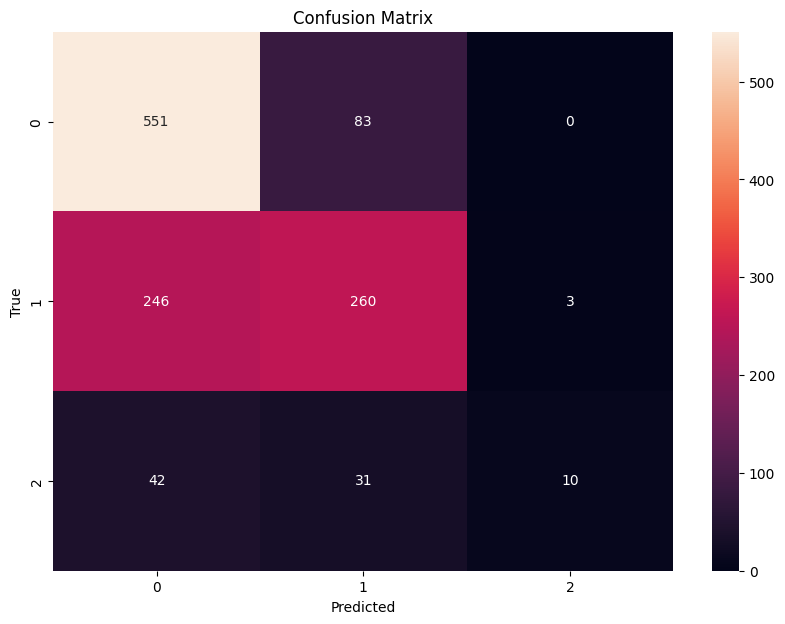

In [46]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



Saving the model

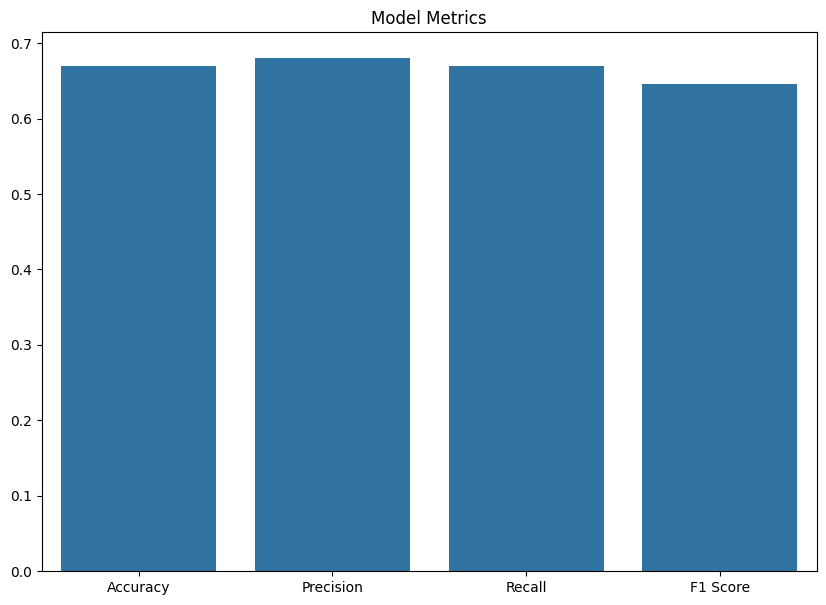

In [47]:
metrics = [accuracy, precision, recall, f1]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(10, 7))
sns.barplot(x=metric_names, y=metrics)
plt.title('Model Metrics')
plt.show()


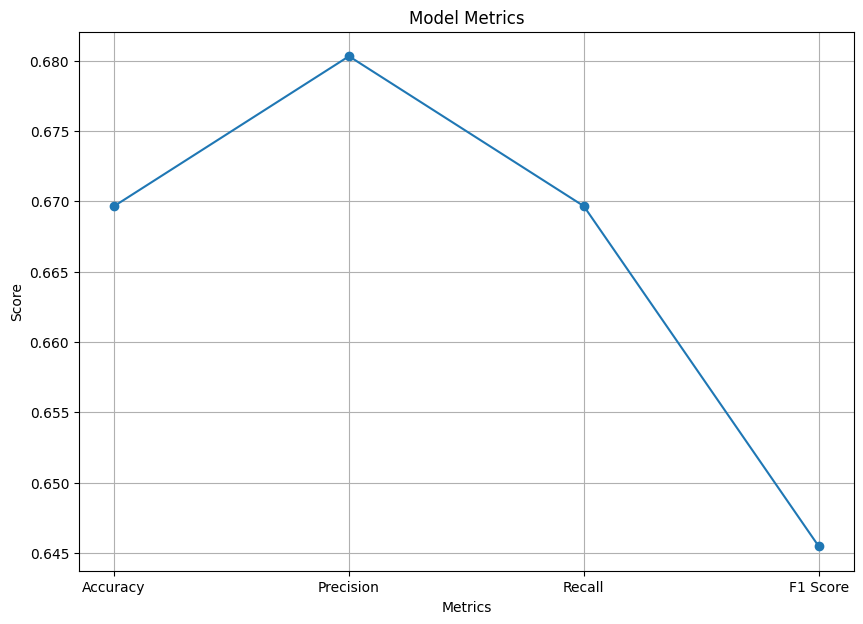

In [48]:
plt.figure(figsize=(10, 7))
plt.plot(metric_names, metrics, marker='o')
plt.title('Model Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.grid(True)
plt.show()

In [49]:
from joblib import dump

dump(grid_search, '../models/complex_sklearn_model.joblib') 

['../models/complex_sklearn_model.joblib']